This notebook will only run if data contains paired data downloaded from the Barts PACS - patients which were enrolled on the local EVINCI substudy (ask Francesca Pugliese about this)

In [1]:
import pydicom as dcm

import numpy as np

import glob

import os

import re

from shutil import copyfile

import matplotlib.pyplot as plt

from network_utils import predict_stochastic
from MultiResUNet.MultiResUNet import MultiResUnet

from mask_utils import load_image,show_image_with_masks

from tensorflow.keras.models import model_from_json

import pickle

import pandas as pd

from scipy.stats import pearsonr

Folder containing all of the pickled, anonymized data...

In [57]:
anonFolder = os.path.join('data','anon')

anonFiles = sorted(glob.glob(os.path.join(anonFolder,'*.pickle')))

subjects = [int(os.path.splitext(os.path.split(d)[1])[0]) for d in anonFiles]

Now, load the model which will be used to make predictions...

In [6]:
#load the model
modelBaseName = 'mrunet_bayesian_2020-07-13_13-40' 

#location of the actual saved model
modelBaseName = os.path.join('data','models',modelBaseName)

modelParamFile = modelBaseName + '.h5'
modelArchitecture = modelBaseName + '.json'

with open( modelArchitecture , 'r') as json_file:
    MODEL = model_from_json( json_file.read() )

MODEL.load_weights(modelParamFile)

#hyperparameter N, defined according to quantify_model_performance.ipynb
N = 15

accuracyModelPath = modelBaseName + '_prediction_conversion.pickle'
ACCURACYMODEL = pickle.load(open(accuracyModelPath,'rb'))


Now, load the details for image preprocessing:


In [9]:
RESNAMES = ['meanArea (cm2)','stdArea (cm2)','predicted DSC']

def quantify_fat(im):
    
    im = im.reshape((1,*im.shape,1))
    res = predict_stochastic(MODEL,N,ACCURACYMODEL,im) 
    
    prediction = res[0]

    #wrap up into a dict for easy DataFram-ing. The first 2 outputs are the actual segmentation and the uncertainty map so not needed in a results table
    resultDict = dict(zip(RESNAMES,res[2:]))

    #ensure that units of area are correct...
    resultDict['meanArea (cm2)'] *= (PXAREA/100)
    resultDict['stdArea (cm2)'] *= (PXAREA/100)
    return resultDict,prediction

C:\Users\BardA\PCF_seg\mask_utils.py:41: UserWarning: Image is larger than padding dimension you specified, so you are losing pixels at the edges
  warnings.warn('Image is larger than padding dimension you specified, so you are losing pixels at the edges')


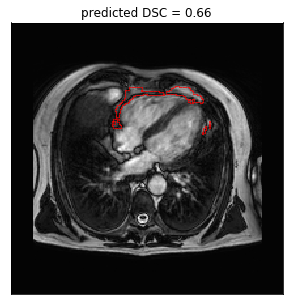

In [110]:

plt.figure(figsize = (5,5))

egFile = anonFiles[eg]
with open(egFile,'rb') as f:
    im = pickle.load(f)['pxArray']
result,mask = quantify_fat(im)
show_image_with_masks(im,mask.squeeze(),{'c':'r','linewidth':0.5})
plt.title('predicted DSC = %.02f'  %result['predicted DSC'])

plt.savefig(os.path.join('graphs','CTComparison','example' + str(eg) + '.png'))
plt.savefig(os.path.join('graphs','CTComparison','example' + str(eg) + '.svg'))

Now, we read the results table from QFAT so we can match up 

In [48]:
QFATresultsFile = os.path.join('data','QFAT_Results.txt')

QFAT = pd.read_csv(QFATresultsFile,index_col = 'Patient_Name')

import pickle
import os
import matplotlib.pyplot as plt

fp = os.path.join('EVINCI','anon','001.pickle')

with open(fp,'rb') as f:
    im = pickle.load(f)

print(im)

In [ ]:
for subject,BTFE in zip(subjects,anonFiles):
    
    if subject in QFAT.index and BTFE is not None:
        with open(BTFE,'rb') as f:
            im = pickle.load(f)['pxArray']
        result,mask = quantify_fat(im)
        QFAT.loc[patient, 'BTFE fat area'] = result['meanArea (cm2)']
        QFAT.loc[patient, 'BTFE predicted DSC'] = result['predicted DSC']

In [ ]:
name,ext = os.path.splitext(QFATresultsFile)
name += '_with_CMR'
outputFile = name+ext
QFAT.to_csv(outputFile)

In [ ]:
plt.figure(figsize = (10,5))

x,y = QFAT[' Thoracic_Fat_volume'],QFAT['BTFE fat area']
notna = ~np.logical_or(np.isnan(x),np.isnan(y))
goodQC = QFAT['BTFE predicted DSC'] > 0.6
badQC = QFAT['BTFE predicted DSC'] < 0.6
good = np.logical_and(goodQC,notna) 
bad = np.logical_and(badQC,notna)
r,p = pearsonr(x[use],y[use])
plt.scatter(x[good],y[good],label = 'predicted DSC > 0.6, n = '+ str(use.sum()))
plt.scatter(x[bad],y[bad],label = 'predicted DSC < 0.6, n = '+ str(badQC.sum()),c='k',alpha = 0.5)
plt.title(' '.join(('pearson r =','%.02f' %r,', p = %.02g' %p) ))
plt.xlabel('Pericardial fat volume from CT/QFAT (cm$^{3}$)')
plt.ylabel('Pericardial fat area from CMR (cm$^{2}$)')
plt.legend()


plt.savefig(os.path.join('graphs','CTComparison','ThoracicFatVolume_BTFE_correlation.png'))
plt.savefig(os.path.join('graphs','CTComparison','ThoracicFatVolume_BTFE_correlation.svg'))

In [ ]:

plt.figure(figsize = (10,5))

x,y = QFAT[' Epicardial_Fat_volume'],QFAT['BTFE fat area']
notna = ~np.logical_or(np.isnan(x),np.isnan(y))
goodQC = QFAT['BTFE predicted DSC'] > 0.6
badQC = QFAT['BTFE predicted DSC'] < 0.6
good = np.logical_and(goodQC,notna) 
bad = np.logical_and(badQC,notna)
r,p = pearsonr(x[use],y[use])
plt.scatter(x[good],y[good],label = 'predicted DSC > 0.6, n = '+ str(use.sum()))
plt.scatter(x[bad],y[bad],label = 'predicted DSC < 0.6, n = '+ str(badQC.sum()),c='k',alpha = 0.5)
plt.title(' '.join(('pearson r =','%.02f' %r,', p = %.02g' %p) ))
plt.xlabel('Pericardial fat volume from CT/QFAT (cm$^{3}$)')
plt.ylabel('Pericardial fat area from CMR (cm$^{2}$)')
plt.legend()

plt.savefig(os.path.join('graphs','CTComparison','EpicardialFatVolume_BTFE_correlation.png'))
plt.savefig(os.path.join('graphs','CTComparison','EpicardialFatVolume_BTFE_correlation.svg'))

In [ ]:
plt.figure(figsize = (5,5))

plt.hist(QFAT['BTFE predicted DSC'],density=True)
plt.ylabel('probability density')
plt.xlabel('predicted Dice score')
plt.xlim([0,1])
plt.savefig(os.path.join('graphs','CTComparison','predictedDice.png'))
plt.savefig(os.path.join('graphs','CTComparison','predictedDice.svg'))